# **Environment configuration**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model

# **Load dataset from Google Drive**

In [ ]:
!unzip /content/drive/MyDrive/Mushrooms.zip -d /content/

Archive:  /content/drive/MyDrive/Mushrooms.zip
replace /content/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Mushrooms/Agaricus/000_ePQknW8cTp8.jpg  
  inflating: /content/Mushrooms/Agaricus/001_2jP9N_ipAo8.jpg  
  inflating: /content/Mushrooms/Agaricus/002_hNh3aQSH-ZM.jpg  
  inflating: /content/Mushrooms/Agaricus/003_4AurAO4Jil8.jpg  
  inflating: /content/Mushrooms/Agaricus/004_Syi3NxxviC0.jpg  
  inflating: /content/Mushrooms/Agaricus/005_sUqyy4Yb9VY.jpg  
  inflating: /content/Mushrooms/Agaricus/006_1_E6AXBJqn4.jpg  
  inflating: /content/Mushrooms/Agaricus/009_mrv34Sn4WiQ.jpg  
  inflating: /content/Mushrooms/Agaricus/010_Rk1D3EG856g.jpg  
  inflating: /content/Mushrooms/Agaricus/011_WtefvQHAs0w.jpg  
  inflating: /content/Mushrooms/Agaricus/012_i_TOGa08rRE.jpg  
  inflating: /content/Mushrooms/Agaricus/013_bhSPsvLNpKk.jpg  
  inflating: /content/Mushrooms/Agaricus/014_DU4RE5bim5A.jpg  
  inflating: /content/Mushrooms/Agari

In [ ]:
instances = []
labels = []
class_id = 0
dataset_path = "/content/Mushrooms"
class_dirs = os.listdir(dataset_path)
for class_dir in class_dirs:
  image_files = os.listdir("%s/%s" % (dataset_path, class_dir))
  for image_file in image_files:
    img_path = "%s/%s/%s" % (dataset_path, class_dir, image_file)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    instances.append(x)
    labels.append(class_id)
  class_id += 1

# **Build training set and test set**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(instances, labels, 
                                                    test_size=0.3, 
                                                    stratify=labels, 
                                                    random_state=123)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                    test_size=0.3, 
                                                    stratify=y_train, 
                                                    random_state=123)

print("Number of training samples: %d" % len(x_train))
print("Number of validation samples: %d" % len(x_val))
print("Number of testing samples: %d" % len(x_test))

Number of training samples: 658
Number of validation samples: 282
Number of testing samples: 404


# **Model No. 1**

<h3>Import VGG16</h3>

In [ ]:
base_model = VGG16(weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<h3>Cut the architecture</h3>

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

<h3>Extract the features</h3>

In [ ]:
x_train_features = []
for x in tqdm(x_train):
  x_features = model.predict(x)
  x_train_features.append(np.array(x_features).flatten())
x_train_features = np.array(x_train_features)

x_val_features = []
for x in tqdm(x_val):
  x_features = model.predict(x)
  x_val_features.append(np.array(x_features).flatten())
x_val_features = np.array(x_val_features)

x_test_features = []
for x in tqdm(x_test):
  x_features = model.predict(x)
  x_test_features.append(np.array(x_features).flatten())
x_test_features = np.array(x_test_features)

100%|██████████| 404/404 [00:17<00:00, 22.92it/s]


<h3>Find a good setting for the hyperparameters of the SVM</h3>

In [ ]:
classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_features, y_train)

print("Results on validation set")
y_pred = classifier.predict(x_val_features)
accuracy1_val = accuracy_score(y_val, y_pred)
print(accuracy1_val)
print(classification_report(y_val, y_pred))

print("Results on training set")
y_pred = classifier.predict(x_train_features)
accuracy1_train = accuracy_score(y_train, y_pred)
print(accuracy1_train)
print(classification_report(y_train, y_pred))

Results on validation set
0.8794326241134752
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        77
           1       0.93      0.88      0.90        65
           2       0.91      0.94      0.93        66
           3       0.84      0.89      0.86        74

    accuracy                           0.88       282
   macro avg       0.88      0.88      0.88       282
weighted avg       0.88      0.88      0.88       282

Results on training set
0.9969604863221885
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       178
           1       1.00      1.00      1.00       152
           2       0.99      1.00      1.00       155
           3       0.99      1.00      1.00       173

    accuracy                           1.00       658
   macro avg       1.00      1.00      1.00       658
weighted avg       1.00      1.00      1.00       658



<h3>Test the model</h3>

In [ ]:
x_train_val_features = np.concatenate((x_train_features, x_val_features))
y_train_val = y_train + y_val

classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_val_features, y_train_val)

print("Results on test set")
y_pred = classifier.predict(x_test_features)

accuracy1_test = accuracy_score(y_test, y_pred)
print(accuracy1_test)
print(classification_report(y_test, y_pred))

Results on test set
0.8811881188118812
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       109
           1       0.87      0.85      0.86        94
           2       0.96      0.95      0.95        95
           3       0.88      0.88      0.88       106

    accuracy                           0.88       404
   macro avg       0.88      0.88      0.88       404
weighted avg       0.88      0.88      0.88       404



# **Model No. 2**

<h3>Cut the architecture and extract the features</h3>

In [ ]:
model = VGG16(weights="imagenet", include_top=False)

x_train_features = []
for x in tqdm(x_train):
  x_features = model.predict(x)
  x_train_features.append(np.array(x_features).flatten())
x_train_features = np.array(x_train_features)

x_val_features = []
for x in tqdm(x_val):
  x_features = model.predict(x)
  x_val_features.append(np.array(x_features).flatten())
x_val_features = np.array(x_val_features)

x_test_features = []
for x in tqdm(x_test):
  x_features = model.predict(x)
  x_test_features.append(np.array(x_features).flatten())
x_test_features = np.array(x_test_features)

100%|██████████| 404/404 [00:16<00:00, 23.92it/s]


<h3>Find a good setting for the hyperparameters of the SVM</h3>

In [ ]:
classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_features, y_train)

print("Results on validation set")
y_pred = classifier.predict(x_val_features)
accuracy2_val = accuracy_score(y_val, y_pred)
print(accuracy2_val)
print(classification_report(y_val, y_pred))

print("Results on training set")
y_pred = classifier.predict(x_train_features)
accuracy2_train = accuracy_score(y_train, y_pred)
print(accuracy2_train)
print(classification_report(y_train, y_pred))

Results on validation set
0.8723404255319149
              precision    recall  f1-score   support

           0       0.80      0.86      0.82        77
           1       0.95      0.89      0.92        65
           2       0.95      0.89      0.92        66
           3       0.83      0.85      0.84        74

    accuracy                           0.87       282
   macro avg       0.88      0.87      0.88       282
weighted avg       0.88      0.87      0.87       282

Results on training set
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       173

    accuracy                           1.00       658
   macro avg       1.00      1.00      1.00       658
weighted avg       1.00      1.00      1.00       658



<h3>Test the model</h3>

In [ ]:
x_train_val_features = np.concatenate((x_train_features, x_val_features))
y_train_val = y_train + y_val

classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_val_features, y_train_val)

print("Results on test set")
y_pred = classifier.predict(x_test_features)

accuracy2_test = accuracy_score(y_test, y_pred)
print(accuracy2_test)
print(classification_report(y_test, y_pred))

Results on test set
0.8787128712871287
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       109
           1       0.88      0.86      0.87        94
           2       0.98      0.95      0.96        95
           3       0.86      0.81      0.83       106

    accuracy                           0.88       404
   macro avg       0.88      0.88      0.88       404
weighted avg       0.88      0.88      0.88       404



# **Model No. 3**

<h3>Cut the architecture</h3>

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("block4_pool").output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

<h3>Extract the features</h3>

In [ ]:
x_train_features = []
for x in tqdm(x_train):
  x_features = model.predict(x)
  x_train_features.append(np.array(x_features).flatten())
x_train_features = np.array(x_train_features)

x_val_features = []
for x in tqdm(x_val):
  x_features = model.predict(x)
  x_val_features.append(np.array(x_features).flatten())
x_val_features = np.array(x_val_features)

x_test_features = []
for x in tqdm(x_test):
  x_features = model.predict(x)
  x_test_features.append(np.array(x_features).flatten())
x_test_features = np.array(x_test_features)

100%|██████████| 404/404 [00:16<00:00, 25.12it/s]


<h3>Find a good setting for the hyperparameters of the SVM</h3>

In [ ]:
classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_features, y_train)

print("Results on validation set")
y_pred = classifier.predict(x_val_features)
accuracy3_val = accuracy_score(y_val, y_pred)
print(accuracy3_val)
print(classification_report(y_val, y_pred))

print("Results on training set")
y_pred = classifier.predict(x_train_features)
accuracy3_train = accuracy_score(y_train, y_pred)
print(accuracy3_train)
print(classification_report(y_train, y_pred))

Results on validation set
0.7588652482269503
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        77
           1       0.85      0.72      0.78        65
           2       0.80      0.85      0.82        66
           3       0.74      0.80      0.77        74

    accuracy                           0.76       282
   macro avg       0.77      0.76      0.76       282
weighted avg       0.76      0.76      0.76       282

Results on training set
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       173

    accuracy                           1.00       658
   macro avg       1.00      1.00      1.00       658
weighted avg       1.00      1.00      1.00       658



<h3>Test the model</h3>

In [ ]:
x_train_val_features = np.concatenate((x_train_features, x_val_features))
y_train_val = y_train + y_val

classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_val_features, y_train_val)

print("Results on test set")
y_pred = classifier.predict(x_test_features)

accuracy3_test = accuracy_score(y_test, y_pred)
print(accuracy3_test)
print(classification_report(y_test, y_pred))

Results on test set
0.7599009900990099
              precision    recall  f1-score   support

           0       0.71      0.78      0.75       109
           1       0.80      0.67      0.73        94
           2       0.82      0.87      0.85        95
           3       0.72      0.72      0.72       106

    accuracy                           0.76       404
   macro avg       0.76      0.76      0.76       404
weighted avg       0.76      0.76      0.76       404



# **Model No. 4**

<h3>Cut the architecture</h3>

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("block3_pool").output)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

<h3>Extract the features</h3>

In [ ]:
x_train_features = []
for x in tqdm(x_train):
  x_features = model.predict(x)
  x_train_features.append(np.array(x_features).flatten())
x_train_features = np.array(x_train_features)

x_val_features = []
for x in tqdm(x_val):
  x_features = model.predict(x)
  x_val_features.append(np.array(x_features).flatten())
x_val_features = np.array(x_val_features)

x_test_features = []
for x in tqdm(x_test):
  x_features = model.predict(x)
  x_test_features.append(np.array(x_features).flatten())
x_test_features = np.array(x_test_features)

100%|██████████| 404/404 [00:14<00:00, 27.93it/s]


<h3>Find a good setting for the hyperparameters of the SVM</h3>

In [ ]:
classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_features, y_train)

print("Results on validation set")
y_pred = classifier.predict(x_val_features)
accuracy4_val = accuracy_score(y_val, y_pred)
print(accuracy4_val)
print(classification_report(y_val, y_pred))

print("Results on training set")
y_pred = classifier.predict(x_train_features)
accuracy4_train = accuracy_score(y_train, y_pred)
print(accuracy4_train)
print(classification_report(y_train, y_pred))

Results on validation set
0.648936170212766
              precision    recall  f1-score   support

           0       0.53      0.51      0.52        77
           1       0.74      0.62      0.67        65
           2       0.70      0.83      0.76        66
           3       0.64      0.66      0.65        74

    accuracy                           0.65       282
   macro avg       0.65      0.65      0.65       282
weighted avg       0.65      0.65      0.65       282

Results on training set
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       173

    accuracy                           1.00       658
   macro avg       1.00      1.00      1.00       658
weighted avg       1.00      1.00      1.00       658



<h3>Test the model</h3>

In [ ]:
x_train_val_features = np.concatenate((x_train_features, x_val_features))
y_train_val = y_train + y_val

classifier = svm.SVC(C=4, kernel="rbf")
classifier.fit(x_train_val_features, y_train_val)

print("Results on test set")
y_pred = classifier.predict(x_test_features)

accuracy4_test = accuracy_score(y_test, y_pred)
print(accuracy4_test)
print(classification_report(y_test, y_pred))

Results on test set
0.6534653465346535
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       109
           1       0.65      0.54      0.59        94
           2       0.71      0.80      0.75        95
           3       0.63      0.69      0.66       106

    accuracy                           0.65       404
   macro avg       0.65      0.65      0.65       404
weighted avg       0.65      0.65      0.65       404



# **Comparison between the three transfer learning methods**

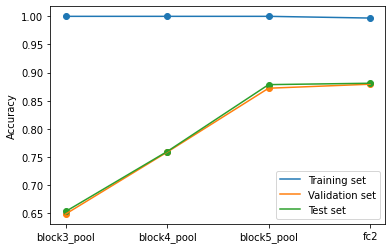

In [ ]:
import matplotlib.pyplot as plt

transfer_learning_cuts = ["block3_pool", "block4_pool",  "block5_pool", "fc2"]

plt.figure()
plt.plot(transfer_learning_cuts, [accuracy4_train, accuracy3_train, accuracy2_train, accuracy1_train])
plt.scatter(transfer_learning_cuts, [accuracy4_train, accuracy3_train, accuracy2_train, accuracy1_train])
plt.plot(transfer_learning_cuts, [accuracy4_val, accuracy3_val, accuracy2_val, accuracy1_val])
plt.scatter(transfer_learning_cuts, [accuracy4_val, accuracy3_val, accuracy2_val, accuracy1_val])
plt.ylabel("Accuracy")
plt.plot(transfer_learning_cuts, [accuracy4_test, accuracy3_test, accuracy2_test, accuracy1_test])
plt.scatter(transfer_learning_cuts, [accuracy4_test, accuracy3_test, accuracy2_test, accuracy1_test])
plt.legend(["Training set", "Validation set", "Test set"])
plt.show()